Yao has suggested that it would be interesting to look at how the 2DHOD (Mass and Concentration or perhaps another parameter) vary with cosmology. I'm going to make a SHAM for Chinchilla and Aardvark and make those plots. 

In [97]:
import numpy as np
import astropy
from scipy.stats import binned_statistic
from pearce.mocks import compute_prim_haloprop_bins, cat_dict
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import hod_from_mock, tpcf, wp, tpcf_one_two_halo_decomp
from pearce.mocks.customHODModels import *

In [98]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle

In [99]:
cosmo_params = { 'Lbox':400.0, 'simname': 'chinchilla', 'scale_factors': [1.0]}

min_ptcl = 200

cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(1.0)
    
halocat = cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] >= min_ptcl*cat.pmass]
halocat = halocat[halocat['halo_upid']==-1]#select only host halos

In [100]:
halocat.colnames

['halo_upid',
 'halo_vacc',
 'halo_vmax',
 'halo_rs_klypin',
 'halo_snapnum',
 'halo_macc',
 'halo_halfmass_scale',
 'halo_y',
 'halo_id',
 'halo_x',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_rvir',
 'halo_vpeak',
 'halo_z',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_hostid',
 'halo_mvir_host_halo']

In [101]:
mag_cut = -21
mag_key = 'halo_vpeak_mag'
sec_haloprop_key = 'halo_vpeak'#'halo_nfw_conc'

In [102]:
galcat = astropy.table.Table.read('abmatched_halos.hdf5', format = 'hdf5')

#rather than rerun my shams, i'm adding some supplementary columns here. These do not work for shuffled cats though! 
#soon i'll just have to rerun the shams to include these

#galcat['halo_macc'] = halocat['halo_macc']
#galcat['halo_vacc'] = halocat['halo_vacc']

galcat = galcat[galcat[mag_key] < mag_cut]

In [103]:
galcat.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_rvir',
 'halo_vpeak',
 'halo_rs_klypin',
 'halo_snapnum',
 'halo_halfmass_scale',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_vpeak_mag',
 'halo_vvir_mag',
 'halo_alpha_05_mag',
 'halo_shuffled_vpeak_mag',
 'halo_shuffled_vvir_mag',
 'halo_shuffled_alpha_05_mag',
 'host_halo_nfw_conc',
 'host_halo_rvir',
 'halo_nfw_x',
 'halo_nfw_y',
 'halo_nfw_z',
 'halo_sh_shuffled_vpeak_mag',
 'halo_sh_shuffled_vvir_mag',
 'halo_sh_shuffled_alpha_05_mag',
 'halo_shuffled_x',
 'halo_shuffled_y',
 'halo_shuffled_z',
 'halo_shuffled_upid',
 'halo_shuffled_host_mvir',
 'halo_sh_shuffled_x',
 'halo_sh_shuffled_y',
 'halo_sh_shuffled_z',
 'halo_sh_shuffled_upid',
 'halo_sh_shuffled_host_mvir',
 'halo_sh_shuffled_cen_vpeak_mag',
 'halo_sh_shuffled_cen_vvir_mag',
 'halo_sh_shuffled_cen_alpha_05_mag',
 'halo_sh_shuffled_cen_x',
 'halo_sh_shuffled_cen_y',
 'halo_sh_shuffled_cen_z',
 'halo_sh_shuffled_c

In [104]:
from collections import Counter
def compute_occupations(halo_catalog, galaxy_catalog):
    #halo_table = cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] > min_ptcl*cat.pmass]

    cens_occ = np.zeros((np.sum(halo_catalog['halo_upid'] == -1),))
    #cens_occ = np.zeros((len(halo_table),))
    sats_occ = np.zeros_like(cens_occ)
    detected_central_ids = set(galaxy_catalog[galaxy_catalog['halo_upid']==-1]['halo_id'])
    detected_satellite_upids = Counter(galaxy_catalog[galaxy_catalog['halo_upid']!=-1]['halo_upid'])

    for idx, row  in enumerate(halo_catalog[halo_catalog['halo_upid'] == -1]):
        cens_occ[idx] = 1.0 if row['halo_id'] in detected_central_ids else 0.0
        sats_occ[idx]+= detected_satellite_upids[row['halo_id']]

    return cens_occ, sats_occ

In [105]:
from math import ceil
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.05):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

In [106]:
cens_occ, sats_occ = compute_occupations(halocat, galcat)

In [107]:
host_halo_mass = halocat[ halocat['halo_upid']==-1]['halo_mvir']
mass_bins = compute_mass_bins(host_halo_mass, 0.2)
mass_bin_centers = (mass_bins[1:]+mass_bins[:-1])/2.0
print mass_bins.shape

(22,)


In [108]:
cenmask = galcat['halo_upid']==-1
satmask = galcat['halo_upid']>0

#halo_mass = halocat['halo_mvir']

cen_hod = hod_from_mock(galcat['halo_mvir_host_halo'][cenmask], host_halo_mass, mass_bins)[0]
sat_hod = hod_from_mock(galcat['halo_mvir_host_halo'][satmask], host_halo_mass, mass_bins)[0]

In [109]:
print len(cens_occ)
print len(host_halo_mass)

1628416
1628416


In [110]:
def var_from_mock(occupations,occupation_haloprop, haloprop_galaxies, haloprop_halos, haloprop_bins=None):
    #same as HOD from mock but does var instead
    _result = binned_statistic(haloprop_galaxies, None, bins=haloprop_bins, statistic='count')
    galaxy_counts, bin_edges, bin_number = _result
    _result = binned_statistic(haloprop_halos, None, bins=haloprop_bins, statistic='count')
    halo_counts, bin_edges, bin_number = _result
    
    mean_occupation = np.zeros(len(haloprop_bins)-1)
    halo_mask = halo_counts > 0
    mean_occupation[halo_mask] = galaxy_counts[halo_mask]/halo_counts[halo_mask].astype('f4')

    var_occupation = np.zeros(len(haloprop_bins)-1)
    
    for i in xrange(len(haloprop_bins)-1):
        if not halo_mask[i]:
            continue
            
        bin_edges = haloprop_bins[i:i+2]
        host_bin_mask = np.logical_and(occupation_haloprop >= bin_edges[0],
                                 occupation_haloprop <=bin_edges[1])
        
        
        varsum = np.sum( (mean_occupation[i]-occupations[host_bin_mask])**2)
        
        bin_mask = np.logical_and(haloprop_halos >= bin_edges[0],
                                 haloprop_halos <=bin_edges[1])
        varsum+= (np.sum(bin_mask)-np.sum(host_bin_mask))*mean_occupation[i]**2
        
        var_occupation[i] =varsum/np.sum(bin_mask) 
        
    return var_occupation


In [111]:
cen_var = var_from_mock(cens_occ, host_halo_mass, galcat['halo_mvir_host_halo'][cenmask], host_halo_mass, mass_bins)
sat_var = var_from_mock(sats_occ, host_halo_mass, galcat['halo_mvir_host_halo'][satmask], host_halo_mass, mass_bins)

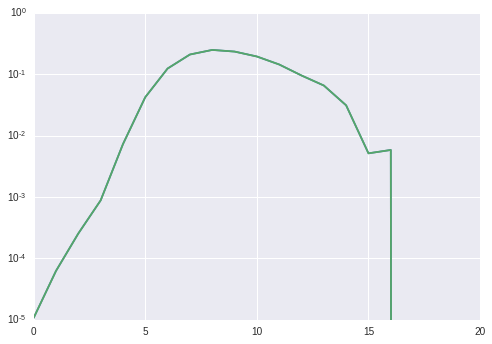

In [112]:
plt.plot(cen_var)
plt.plot(cen_hod*(1-cen_hod))
plt.yscale('log')

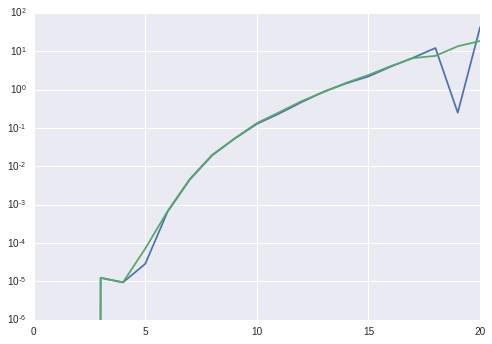

In [113]:
plt.plot(sat_var)
plt.plot(sat_hod)
plt.yscale('log')

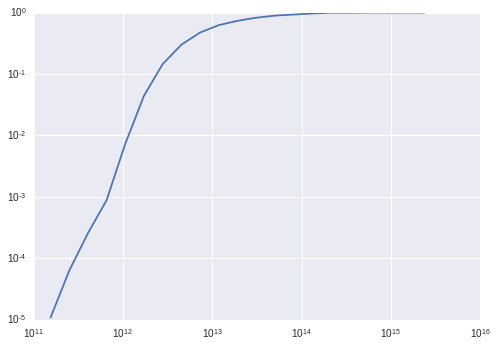

In [114]:
plt.plot(mass_bin_centers, cen_hod)
plt.loglog();

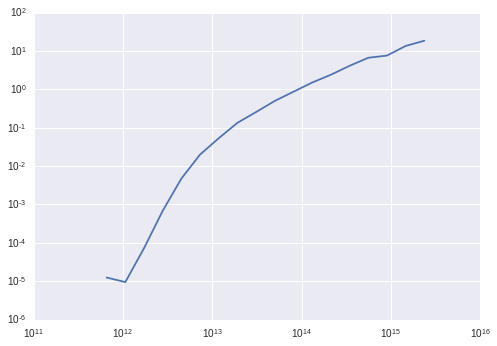

In [115]:
plt.plot(mass_bin_centers, sat_hod)
plt.loglog();

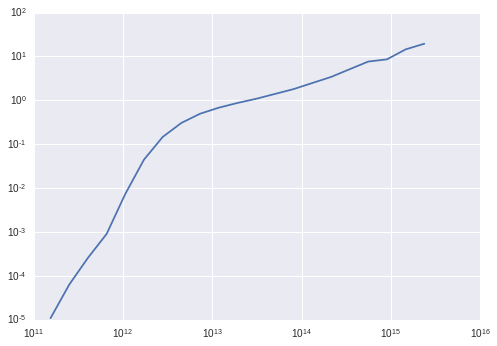

In [116]:
plt.plot(mass_bin_centers, cen_hod+sat_hod)
plt.loglog();

In [117]:
conc_bins = np.linspace(0, 1, 21)#np.linspace(0, 1000, 10)#np.linspace(0, 22, 10)

In [118]:
#sns.set_palette(sns.diverging_palette(255, 133, l=60, n=22, center="light"))
colors =sns.cubehelix_palette(22,start=.5, rot=-.75)

In [119]:
def calc_2dhod(mass_bins,conc_bins, cens_occ, sats_occ,halocat, sec_haloprop_key, galcat = None):
    
    halo_mass = halocat['halo_mvir']
    halo_sec =halocat[sec_haloprop_key]
    if galcat is None:
        host_halo_mass = halocat[halocat['halo_upid']==-1]['halo_mvir']
        host_halo_sec =halocat[ halocat['halo_upid']==-1][sec_haloprop_key]
    else:
        host_halo_mass = galcat['halo_mvir']
        host_halo_sec = galcat[sec_haloprop_key]

    
    host_mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop = host_halo_mass)
    mass_bin_idxs = compute_prim_haloprop_bins(prim_haloprop_bin_boundaries=mass_bins, prim_haloprop = halo_mass)


    #host_conditional_conc_percentiles = compute_conditional_percentiles(prim_haloprop  = host_halo_mass,\
    #                                                              sec_haloprop = host_halo_conc,\
    #                                                              prim_haloprop_bin_boundaries = mass_bins)
    conditional_sec_percentiles = compute_conditional_percentiles(prim_haloprop  = halo_mass,\
                                                                  sec_haloprop = halo_sec,\
                                                                  prim_haloprop_bin_boundaries = mass_bins)
    
    if galcat is None:
        host_conditional_sec_percentiles = conditional_sec_percentiles[halocat['halo_upid']==-1]
    else:
        host_conditional_sec_percentiles = np.zeros((len(galcat),))
        host_halocat_idxs = np.in1d(halocat['halo_id'], galcat['halo_hostid'], assume_unique=True)
        host_sort_idxs = np.argsort(galcat['halo_hostid'])
        sort_idxs = np.argsort(halocat[host_halocat_idxs]['halo_id'])
        host_conditional_sec_percentiles[host_sort_idxs] = conditional_sec_percentiles[host_halocat_idxs][sort_idxs]


    mean_ncen = np.zeros((len(mass_bins)-1, len(conc_bins)-1))
    mean_nsat = np.zeros((len(mass_bins)-1, len(conc_bins)-1))
    
    var_ncen = np.zeros((len(mass_bins)-1, len(conc_bins)-1))
    var_nsat = np.zeros((len(mass_bins)-1, len(conc_bins)-1))
    
    mass_bin_nos = range(1,len(mass_bins)-1,1)
    

    for bin_no in mass_bin_nos:
        bin_center = np.mean(mass_bins[bin_no-1:bin_no+1])
        indices_of_host_mb = np.where(host_mass_bin_idxs == bin_no)[0]
        indices_of_mb = np.where(mass_bin_idxs == bin_no)[0]
        
        if len(indices_of_mb) == 0:
            continue
        
        #cens_sum, sats_sum = np.sum(cens_occ[indices_of_mb]), np.sum(sats_occ[indices_of_mb])

        (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(host_conditional_sec_percentiles[indices_of_host_mb],\
                                                                      cens_occ[indices_of_host_mb],bins=conc_bins, statistic='sum'), \
                                   binned_statistic(host_conditional_sec_percentiles[indices_of_host_mb],\
                                                                      sats_occ[indices_of_host_mb],bins=conc_bins,statistic='sum')

        binned_halos, _, _ = binned_statistic(conditional_sec_percentiles[indices_of_mb],
                                                 None, bins=conc_bins, statistic='count')
    

        mean_ncen[bin_no-1,:] = binned_cens/binned_halos
        mean_nsat[bin_no-1,:] = binned_sats/binned_halos

        for i in xrange(mean_ncen.shape[1]):
            bin_edges = conc_bins[i:i+2]
            host_bin_idxs = np.logical_and(host_conditional_sec_percentiles[indices_of_host_mb] >= bin_edges[0],
                                     host_conditional_sec_percentiles[indices_of_host_mb] <= bin_edges[1])

            varsum_cens = np.sum((mean_ncen[bin_no-1, i] - cens_occ[indices_of_host_mb][host_bin_idxs])**2)
            varsum_sats = np.sum((mean_nsat[bin_no-1, i] - sats_occ[indices_of_host_mb][host_bin_idxs])**2)

            bin_idxs = np.logical_and(conditional_sec_percentiles[indices_of_mb] >= bin_edges[0],
                                     conditional_sec_percentiles[indices_of_mb] <= bin_edges[1])

            var_ncen[bin_no-1, i] = (varsum_cens + (np.sum(bin_idxs)-np.sum(host_bin_idxs))*mean_ncen[bin_no-1,i]**2)/np.sum(bin_idxs) #account for non host halos in this mass bin
            var_nsat[bin_no-1, i] = (varsum_sats + (np.sum(bin_idxs)-np.sum(host_bin_idxs))*mean_nsat[bin_no-1,i]**2)/np.sum(bin_idxs) #account for non host halos in this mass bin
            #var_ncen[bin_no-1, i] = (varsum_cens)/len(host_bin_idxs) #account for non host halos in this mass bin
            #var_nsat[bin_no-1, i] = (varsum_sats)/len(host_bin_idxs) #account for non host halos in this mass bin

            #print np.sum(sats_occ[indices_of_host_mb][host_bin_idxs]),
            #print (len(bin_idxs)-len(host_bin_idxs)), np.log10(bin_center)

        if np.any(np.isnan(mean_ncen[bin_no-1,:])):
            mean_ncen[bin_no-1,np.isnan(mean_ncen[bin_no-1,:])] = cen_hod[bin_no-1]

        if np.any(np.isnan(mean_nsat[bin_no-1,:])):
            mean_nsat[bin_no-1,np.isnan(mean_nsat[bin_no-1,:] )] = sat_hod[bin_no-1]
            
    return mean_ncen, mean_nsat, var_ncen, var_nsat

    #mean_ncen[np.isnan(mean_ncen)] = 0.0
    #mean_nsat[np.isnan(mean_nsat)] = 0.0

In [120]:
mean_ncen, mean_nsat, var_ncen, var_nsat = calc_2dhod(mass_bins,conc_bins, cens_occ, sats_occ,halocat, sec_haloprop_key)

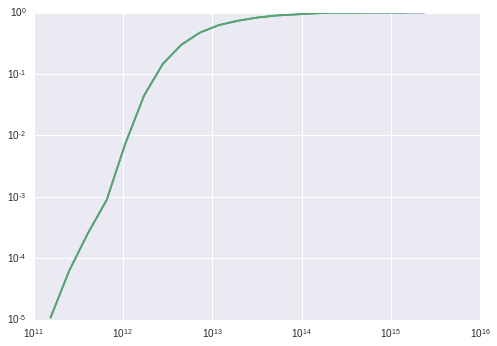

In [121]:
plt.plot(mass_bin_centers, cen_hod)
plt.plot(mass_bin_centers, mean_ncen.mean(axis=1))

plt.loglog();

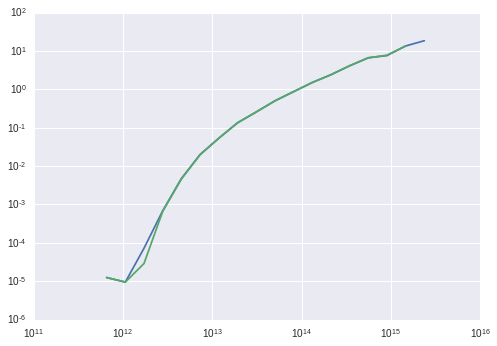

In [122]:
plt.plot(mass_bin_centers, sat_hod)
plt.plot(mass_bin_centers, mean_nsat.mean(axis=1))

plt.loglog();

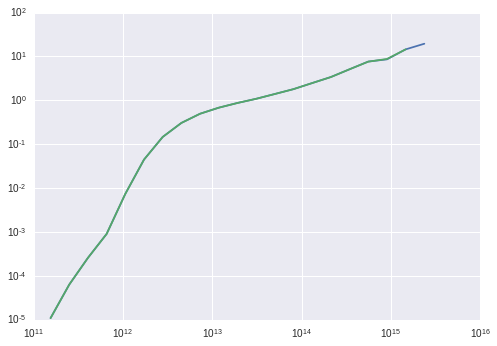

In [123]:
plt.plot(mass_bin_centers, cen_hod+sat_hod)
plt.plot(mass_bin_centers, mean_ncen.mean(axis=1)+mean_nsat.mean(axis=1))

plt.loglog();

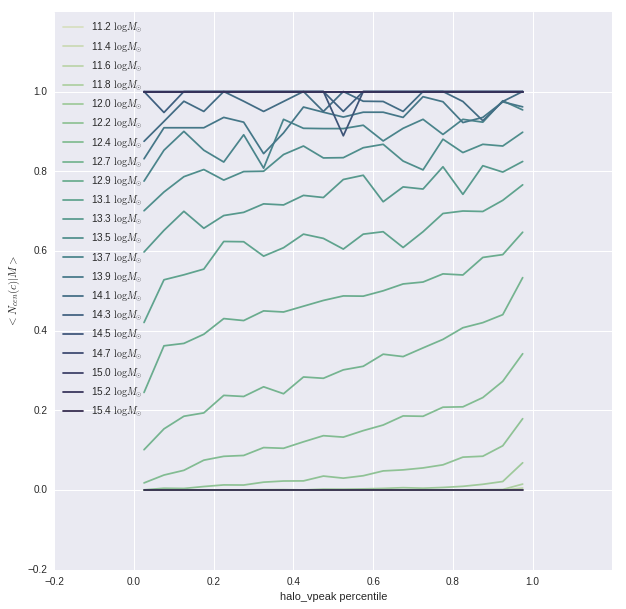

In [124]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
for row,c,m in zip(mean_ncen, colors, mass_bin_centers):
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    
plt.ylim(-0.2,1.2)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%sec_haloprop_key)
plt.ylabel(r'$<N_{cen}(c)|M>$')
plt.legend(loc='best')

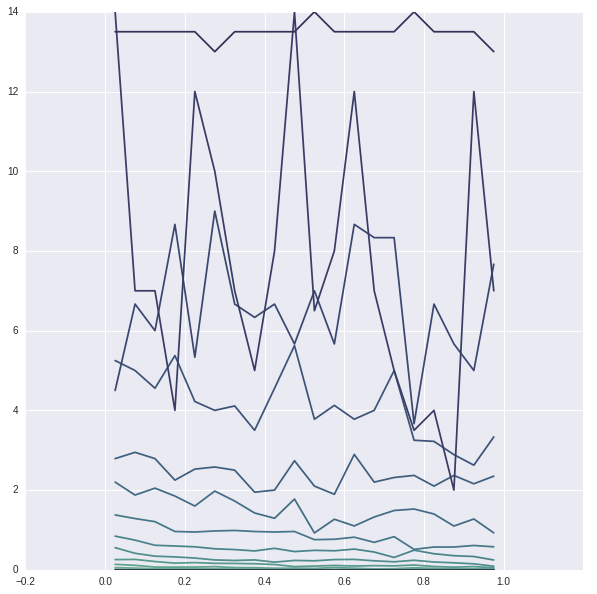

In [125]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
for row,c  in zip(mean_nsat, colors):
    plt.plot(cbc, row, color = c)
    
#plt.ylim(-0.2,1.2)
plt.xlim(-0.2, 1.2);


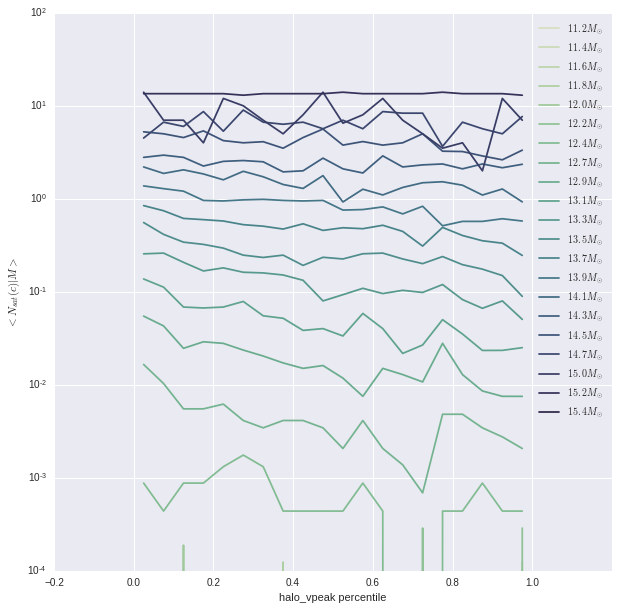

In [126]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
for row,c,m  in zip(mean_nsat, colors,mass_bin_centers):
    plt.plot(cbc, row, color = c, label = '$%.1f M_{\odot}$'%np.log10(m))
    
#plt.ylim(-0.2,1.2)
plt.xlim(-0.2, 1.2);
plt.yscale('log')
plt.xlabel('%s percentile'%sec_haloprop_key)
plt.ylabel(r'$<N_{sat}(c)|M>$')
plt.legend(loc='best')

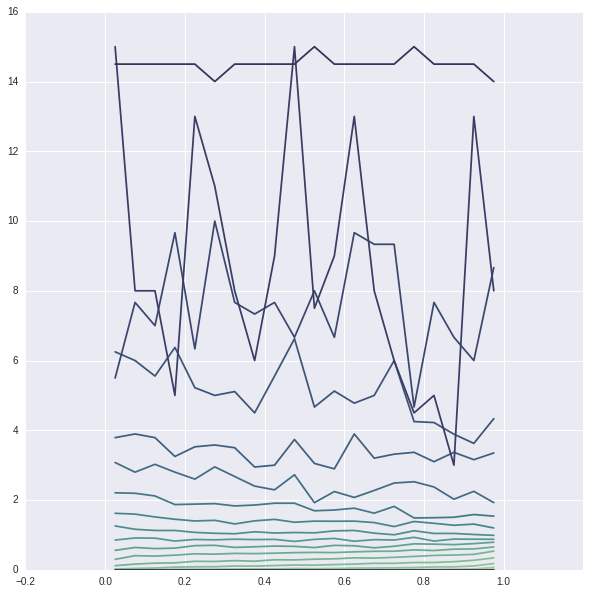

In [127]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
for crow, srow,c  in zip(mean_ncen, mean_nsat, colors):
    plt.plot(cbc, crow+srow, color = c)
    
#plt.ylim(-0.2,1.2)
plt.xlim(-0.2, 1.2);

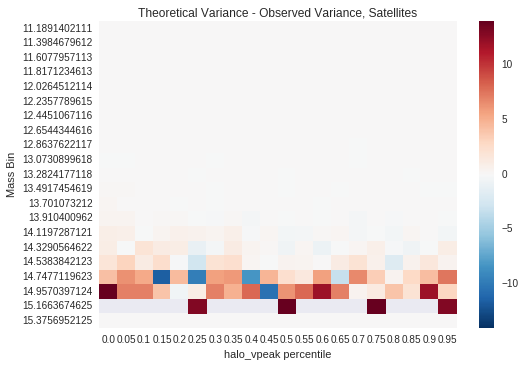

In [128]:
sns.heatmap(mean_nsat-var_nsat, center = 0.0, xticklabels = conc_bins[:-1], yticklabels = np.log10(mass_bin_centers))
plt.ylabel('Mass Bin')
plt.xlabel('%s percentile'%sec_haloprop_key)
plt.title(r"Theoretical Variance - Observed Variance, Satellites")

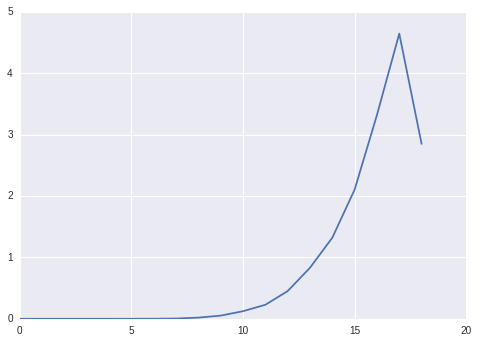

In [129]:
#plt.plot(mean_nsat.mean(axis=1))
plt.plot(var_nsat.mean(axis=1))

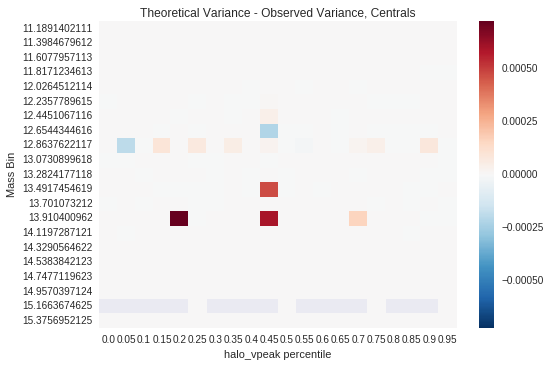

In [130]:
sns.heatmap(mean_ncen*(1-mean_ncen)-var_ncen, center = 0.0,xticklabels = conc_bins[:-1], yticklabels = np.log10(mass_bin_centers))
plt.ylabel('Mass Bin')
plt.xlabel('%s percentile'%sec_haloprop_key)
plt.title(r"Theoretical Variance - Observed Variance, Centrals")

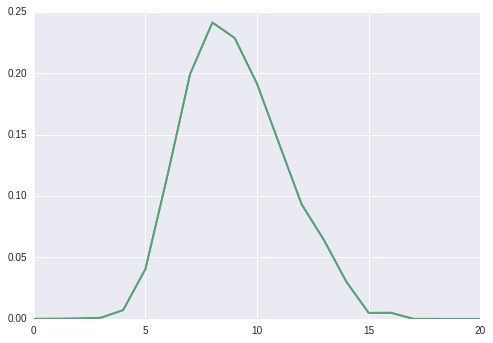

In [131]:
plt.plot(var_ncen.mean(axis=1))
plt.plot((mean_ncen*(1-mean_ncen)).mean(axis=1))

In [132]:
print mass_bin_centers.shape
print cbc.shape
print mean_ncen.shape
print mean_nsat.shape

(21,)
(20,)
(21, 20)
(21, 20)


In [133]:
cat.load_model(1.0, HOD=(Tabulated2DCens, Tabulated2DSats), hod_kwargs = {'prim_haloprop_bins': mass_bins,
                                                               'sec_haloprop_perc_bins': conc_bins,
                                                                'sec_haloprop_key': sec_haloprop_key,
                                                               'cen_hod_vals':mean_ncen,
                                                               'sat_hod_vals':mean_nsat})

In [134]:
cat.populated_once = False
cat.populate({})

In [135]:
rbins = np.logspace(-1, 1.7, 18)
rpoints = (rbins[1:]+rbins[:-1])/2

In [136]:
hod_xi = cat.calc_xi(rbins, do_jackknife=False)

In [ ]:
hod_wp = cat.calc_wp(rbins)#, do_jackkinfe=False)

In [ ]:
pos = np.c_[galcat['halo_x'], galcat['halo_y'], galcat['halo_z']]
sham_xi = tpcf(pos*cat.h, rbins, period=cat.Lbox*cat.h)
sham_wp = wp(pos*cat.h,rbins, 40*cat.h, period=cat.Lbox*cat.h )

In [ ]:
pos = np.c_[galcat['halo_nfw_x'], galcat['halo_nfw_y'], galcat['halo_nfw_z']]
sham_nfw_xi = tpcf(pos*cat.h, rbins, period=cat.Lbox*cat.h)
sham_nfw_wp = wp(pos*cat.h,rbins, 40*cat.h, period=cat.Lbox*cat.h )

In [ ]:
rpoints = (rbins[1:]+rbins[:-1])/2.0

In [ ]:
fig = plt.figure(figsize = (8,8))
#plt.subplot(121)
#plt.plot(rpoints, hod_xi, label = 'HOD xi')
#plt.plot(rpoints, sham_xi, label = 'SHAM  xi')
#plt.plot(rpoints, sham_nfw_xi, label = 'SHAM NFW-ized xi')
#plt.subplot(122)
plt.plot(rpoints, sham_xi/hod_xi, label = 'Normal SHAM',color = 'g')
plt.plot(rpoints, sham_nfw_xi/hod_xi, label = 'NFW SHAM',color = 'r')

#plt.subplot(121)
#plt.loglog()
#plt.legend(loc='best')
#plt.xlabel('r [Mpc]', fontsize = 25)
#plt.ylabel(r'$\xi(r)$',fontsize = 25)
#plt.subplot(122)
plt.xscale('log')
plt.xlabel('r [Mpc]',fontsize = 25)
plt.ylabel(r'SHAM $\xi$/HOD $\xi$',fontsize = 25)
plt.suptitle('Tabulated 2DHOD vs SHAM Clustering %s'%sec_haloprop_key,fontsize = 30)

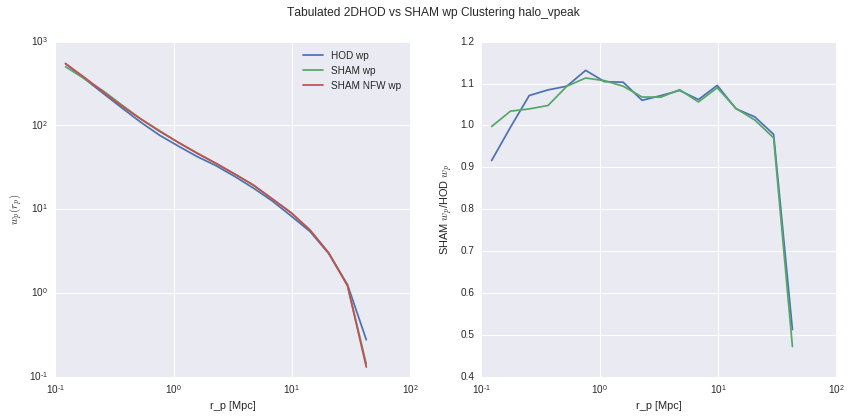

In [47]:
fig = plt.figure(figsize = (14,6))
plt.subplot(121)
plt.plot(rpoints, hod_wp, label = 'HOD wp')
plt.plot(rpoints, sham_wp, label = 'SHAM wp')
plt.plot(rpoints, sham_nfw_wp, label = 'SHAM NFW wp')
plt.subplot(122)
plt.plot(rpoints, sham_wp/hod_wp, label = 'Normal SHAM')
plt.plot(rpoints, sham_nfw_wp/hod_wp, label = 'NFW SHAM')

plt.subplot(121)
plt.loglog()
plt.legend(loc='best')
plt.xlabel('r_p [Mpc]')
plt.ylabel(r'$w_p(r_p)$')
plt.subplot(122)
plt.xscale('log')
plt.xlabel('r_p [Mpc]')
plt.ylabel(r'SHAM $w_p$/HOD $w_p$')
plt.suptitle('Tabulated 2DHOD vs SHAM wp Clustering %s'%sec_haloprop_key)

In [ ]:
hodcat = cat.model.mock.galaxy_table

In [ ]:
unique_hostids, unique_idxs = np.unique(hodcat['halo_hostid'], return_index=True)
unique_hodcat = hodcat[unique_idxs]

In [ ]:
hod_mean_ncen, hod_mean_nsat, hod_var_ncen, hod_var_nsat = \
            calc_2dhod(mass_bins,conc_bins, unique_hodcat['halo_num_centrals'], unique_hodcat['halo_num_satellites'],halocat,\
                       sec_haloprop_key, galcat = unique_hodcat)

In [ ]:
sns.heatmap(hod_var_ncen-var_ncen, center = 0.0, xticklabels = conc_bins[:-1], yticklabels = np.log10(mass_bin_centers))
plt.ylabel('Mass Bin')
plt.xlabel('%s percentile'%sec_haloprop_key)
plt.title(r"HOD Variance - SHAM Variance, Centrals")

In [ ]:
sns.heatmap(hod_mean_ncen-mean_ncen, center = 0.0, xticklabels = conc_bins[:-1], yticklabels = np.log10(mass_bin_centers))
plt.ylabel('Mass Bin')
plt.xlabel('%s percentile'%sec_haloprop_key)
plt.title(r"HOD Mean - SHAM Mean, Centrals")

In [ ]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
for row, hod_row,c,m in zip(mean_ncen, hod_mean_ncen, colors, mass_bin_centers):
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    plt.plot(cbc, hod_row, color = c, ls = '--', lw = 3)

    
plt.ylim(-0.2,1.2)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%sec_haloprop_key)
plt.ylabel(r'$<N_{cen}(c)|M>$')
plt.legend(loc='best')

In [ ]:
fig = plt.figure(figsize = (10,10))
cbc = (conc_bins[1:]+conc_bins[:-1])/2.0
for row, hod_row,c,m in zip(mean_nsat, hod_mean_nsat, colors, mass_bin_centers):
    plt.plot(cbc, row, color = c, label = r'%.1f $\log M_{\odot}$'%np.log10(m))
    plt.plot(cbc, hod_row, color = c, ls = '--', lw = 3)

    
#plt.ylim(-0.2,1.2)
plt.xlim(-0.2, 1.2);
plt.xlabel('%s percentile'%sec_haloprop_key)
plt.ylabel(r'$<N_{cen}(c)|M>$')
plt.legend(loc='best')
plt.yscale('log')

In [ ]:
test_cen_hod = hod_from_mock(hodcat['halo_mvir'][hodcat['gal_type']=='centrals']\
                             , halocat['halo_mvir'], mass_bins)[0]

In [ ]:
mean_ncen.mean(axis=1)/test_cen_hod

In [ ]:
hod_mean_ncen.mean(axis=1)/test_cen_hod

In [ ]:
cat.model.model_dictionary['centrals_occupation']._cen_hod_vals.mean(axis=1)/test_cen_hod

In [ ]:
hodcat.colnames

In [ ]:
test_sat_hod = hod_from_mock(hodcat['halo_mvir'][hodcat['gal_type'] == 'satellites']\
                             , halocat['halo_mvir'], mass_bins)[0]

In [ ]:
test_sat_hod

In [ ]:
cat.model.model_dictionary['satellites_occupation']._sat_hod_vals.mean(axis=1)/test_sat_hod

In [ ]:
len(cat.halocat.halo_table)

In [ ]:
len(halocat[halocat['halo_upid']==-1])

In [ ]:
len(cat.model.mock.halo_table)

In [ ]:
len(cat.model.mock._orig_halo_table)

In [ ]:
print cat.model.mock.Num_ptcl_requirement
print cat.model.mock.particle_mass


In [ ]:
cat.pmass

In [ ]:
cut_idxs = np.in1d(halocat['halo_id'], cat.model.mock.halo_table['halo_id'], invert=True)

In [ ]:
plt.hist(halocat['halo_mvir'], bins = mass_bins)
plt.hist(cat.model.mock.halo_table['halo_mvir'], bins = mass_bins)
plt.hist(halocat[cut_idxs]['halo_mvir'], bins = mass_bins)

plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(mass_bin_centers, hod_mean_ncen.mean(axis=1))
plt.plot(mass_bin_centers, mean_ncen.mean(axis=1))
plt.plot(mass_bin_centers, test_cen_hod)
#plt.loglog()
plt.xscale('log')

In [ ]:
plt.plot(mass_bin_centers, hod_mean_nsat.mean(axis=1))
plt.plot(mass_bin_centers, mean_nsat.mean(axis=1))
plt.plot(mass_bin_centers, test_sat_hod)
plt.loglog()

In [ ]:
sns.heatmap(hod_var_nsat-var_nsat, center = 0.0, xticklabels = conc_bins[:-1], yticklabels = np.log10(mass_bin_centers))
plt.ylabel('Mass Bin')
plt.xlabel('%s percentile'%sec_haloprop_key)
plt.title(r"HOD Variance - SHAM Variance, Satellites")

In [ ]:
sns.heatmap(hod_mean_nsat-mean_nsat, center = 0.0, xticklabels = conc_bins[:-1], yticklabels = np.log10(mass_bin_centers))
plt.ylabel('Mass Bin')
plt.xlabel('%s percentile'%sec_haloprop_key)
plt.title(r"HOD Mean - SHAM Mean, Satellites")

In [ ]:
from collections import Counter
c = Counter(hodcat['halo_hostid'])
c.most_common(10)

In [ ]:
pos = np.c_[hodcat['x'], hodcat['y'], hodcat['z']]
hod_1h_xi, hod_2h_xi = tpcf_one_two_halo_decomp(pos*cat.h, hodcat['halo_hostid'],rbins, period = cat.Lbox*cat.h)

In [ ]:
pos = np.c_[galcat['halo_x'], galcat['halo_y'], galcat['halo_z']]
sham_1h_xi, sham_2h_xi = tpcf_one_two_halo_decomp(pos*cat.h, galcat['halo_hostid'],rbins, period = cat.Lbox*cat.h)

In [ ]:
fig = plt.figure(figsize = (14,6))

plt.subplot(121)
plt.plot(rpoints, hod_xi, label = 'HOD xi', c = colors[5])
plt.plot(rpoints, sham_xi, label = 'SHAM xi', c = colors[-5])

plt.plot(rpoints, hod_1h_xi,c = colors[5], ls = '--')
plt.plot(rpoints, sham_1h_xi,c = colors[-5], ls = '--')

plt.plot(rpoints, hod_2h_xi,c = colors[5], ls = ':')
plt.plot(rpoints, sham_2h_xi,c = colors[-5], ls = ':')

plt.subplot(122)
plt.plot(rpoints, sham_xi/hod_xi, label = 'Full')
plt.plot(rpoints, sham_1h_xi/hod_1h_xi, ls = '--', label = 'One Halo')
plt.plot(rpoints, sham_2h_xi/hod_2h_xi, ls = ':', label = 'Two Halo')

plt.subplot(121)
plt.loglog()
plt.legend(loc='best')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi(r)$')
plt.subplot(122)
plt.xscale('log')
plt.xlabel('r [Mpc]')
plt.ylabel(r'SHAM $\xi$/HOD $\xi$')
plt.ylim([0, 2])
plt.legend(loc='best')
plt.suptitle('Tabulated 2DHOD vs SHAM Clustering %s'%sec_haloprop_key)

In [ ]:
mlim = 1e13

In [ ]:
mass_cut = hodcat['halo_mvir'] >= mlim
pos = np.c_[hodcat['x'], hodcat['y'], hodcat['z']]
hod_xi_mc = tpcf(pos[mass_cut]*cat.h,rbins, period = cat.Lbox*cat.h)
hod_1h_xi_mc, hod_2h_xi_mc = tpcf_one_two_halo_decomp(pos[mass_cut]*cat.h, hodcat[mass_cut]['halo_hostid'],rbins, period = cat.Lbox*cat.h)

In [ ]:
print np.sum(mass_cut)*1.0/pos.shape[0]

In [ ]:
mass_cut = galcat['halo_mvir_host_halo'] >= mlim
pos = np.c_[galcat['halo_x'], galcat['halo_y'], galcat['halo_z']]
sham_xi_mc = tpcf(pos[mass_cut]*cat.h,rbins, period = cat.Lbox*cat.h)
sham_1h_xi_mc, sham_2h_xi_mc = tpcf_one_two_halo_decomp(pos[mass_cut]*cat.h, galcat[mass_cut]['halo_hostid'],rbins, period = cat.Lbox*cat.h)

In [ ]:
print np.sum(mass_cut)*1.0/pos.shape[0]

In [ ]:
fig = plt.figure(figsize = (14,6))

plt.subplot(121)
plt.plot(rpoints, hod_xi_mc, label = 'HOD xi', c = colors[5])
plt.plot(rpoints, sham_xi_mc, label = 'SHAM xi', c = colors[-5])

plt.plot(rpoints, hod_1h_xi_mc,c = colors[5], ls = '--')
plt.plot(rpoints, sham_1h_xi_mc,c = colors[-5], ls = '--')

plt.plot(rpoints, hod_2h_xi_mc,c = colors[5], ls = ':')
plt.plot(rpoints, sham_2h_xi_mc,c = colors[-5], ls = ':')

plt.subplot(122)
plt.plot(rpoints, (sham_xi_mc)/(hod_xi_mc), label = 'Full')
plt.plot(rpoints, sham_1h_xi_mc/hod_1h_xi_mc, ls = '--', label = 'One Halo')
plt.plot(rpoints, sham_2h_xi_mc/hod_2h_xi_mc, ls = ':', label = 'Two Halo')

plt.subplot(121)
plt.loglog()
plt.legend(loc='best')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi(r)$')
plt.subplot(122)
plt.xscale('log')
plt.xlabel('r [Mpc]')
plt.ylabel(r'SHAM $\xi$/HOD $\xi$')
plt.ylim([0, 2])
plt.legend(loc='best')
plt.suptitle('Tabulated 2DHOD vs SHAM Clustering %s, M > 1e13 Msun'%sec_haloprop_key)

In [ ]:
type_cut = hodcat['gal_type'] != 'centrals'
pos = np.c_[hodcat['x'], hodcat['y'], hodcat['z']]
hod_xi_tc = tpcf(pos[type_cut]*cat.h,rbins, period = cat.Lbox*cat.h)
hod_1h_xi_tc, hod_2h_xi_tc = tpcf_one_two_halo_decomp(pos[type_cut]*cat.h, hodcat[type_cut]['halo_hostid'],rbins, period = cat.Lbox*cat.h)

In [ ]:
print np.sum(type_cut)*1.0/pos.shape[0]

In [ ]:
type_cut = galcat['halo_upid'] != -1
pos = np.c_[galcat['halo_x'], galcat['halo_y'], galcat['halo_z']]
sham_xi_tc = tpcf(pos[type_cut]*cat.h,rbins, period = cat.Lbox*cat.h)
sham_1h_xi_tc, sham_2h_xi_tc = tpcf_one_two_halo_decomp(pos[type_cut]*cat.h, galcat[type_cut]['halo_hostid'],rbins, period = cat.Lbox*cat.h)

In [ ]:
print np.sum(type_cut)*1.0/pos.shape[0]

In [ ]:
fig = plt.figure(figsize = (14,6))

plt.subplot(121)
plt.plot(rpoints, hod_xi_tc, label = 'HOD xi', c = colors[5])
plt.plot(rpoints, sham_xi_tc, label = 'SHAM xi', c = colors[-5])

plt.plot(rpoints, hod_1h_xi_tc,c = colors[5], ls = '--')
plt.plot(rpoints, sham_1h_xi_tc,c = colors[-5], ls = '--')

plt.plot(rpoints, hod_2h_xi_tc,c = colors[5], ls = ':')
plt.plot(rpoints, sham_2h_xi_tc,c = colors[-5], ls = ':')

plt.subplot(122)
plt.plot(rpoints, (sham_xi_tc)/(hod_xi_tc), label = 'Full')
plt.plot(rpoints, sham_1h_xi_tc/hod_1h_xi_tc, ls = '--', label = 'One Halo')
plt.plot(rpoints, sham_2h_xi_tc/hod_2h_xi_tc, ls = ':', label = 'Two Halo')

plt.subplot(121)
plt.loglog()
plt.legend(loc='best')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi(r)$')
plt.subplot(122)
plt.xscale('log')
plt.xlabel('r [Mpc]')
plt.ylabel(r'SHAM $\xi$/HOD $\xi$')
plt.ylim([0, 2])
plt.legend(loc='best')
plt.suptitle('Tabulated 2DHOD vs SHAM Clustering %s'%sec_haloprop_key)

In [ ]:
splashback_idxs = halocat['halo_first_acc_scale']<1.0

In [ ]:
type_cut = np.in1d(hodcat['halo_hostid'], halocat[splashback_idxs]['halo_id'])#, hodcat['gal_type'] == 'centrals')
pos = np.c_[hodcat['x'], hodcat['y'], hodcat['z']]
hod_xi_sb = tpcf(pos[type_cut]*cat.h,rbins, period = cat.Lbox*cat.h)
hod_1h_xi_sb, hod_2h_xi_sb = tpcf_one_two_halo_decomp(pos[type_cut]*cat.h, hodcat[type_cut]['halo_hostid'],rbins, period = cat.Lbox*cat.h)

In [ ]:
print np.sum(type_cut)*1.0/pos.shape[0]

In [ ]:
type_cut = np.in1d(galcat['halo_hostid'], halocat[splashback_idxs]['halo_id'])
pos = np.c_[galcat['halo_x'], galcat['halo_y'], galcat['halo_z']]
sham_xi_sb = tpcf(pos[type_cut]*cat.h,rbins, period = cat.Lbox*cat.h)
sham_1h_xi_sb, sham_2h_xi_sb = tpcf_one_two_halo_decomp(pos[type_cut]*cat.h, galcat[type_cut]['halo_hostid'],rbins, period = cat.Lbox*cat.h)

In [ ]:
print np.sum(type_cut)*1.0/pos.shape[0]

In [ ]:
fig = plt.figure(figsize = (14,6))

plt.subplot(121)
plt.plot(rpoints, hod_xi_sb, label = 'HOD xi', c = colors[5])
plt.plot(rpoints, sham_xi_sb, label = 'SHAM xi', c = colors[-5])

plt.plot(rpoints, hod_1h_xi_sb,c = colors[5], ls = '--')
plt.plot(rpoints, sham_1h_xi_sb,c = colors[-5], ls = '--')

plt.plot(rpoints, hod_2h_xi_sb,c = colors[5], ls = ':')
plt.plot(rpoints, sham_2h_xi_sb,c = colors[-5], ls = ':')

plt.subplot(122)
plt.plot(rpoints, (sham_xi_sb)/(hod_xi_sb), label = 'Full')
plt.plot(rpoints, sham_1h_xi_sb/hod_1h_xi_sb, ls = '--', label = 'One Halo')
plt.plot(rpoints, sham_2h_xi_sb/hod_2h_xi_sb, ls = ':', label = 'Two Halo')

plt.subplot(121)
plt.loglog()
plt.legend(loc='best')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi(r)$')
plt.ylim(1e-2, 1e4)
plt.subplot(122)
plt.xscale('log')
plt.xlabel('r [Mpc]')
plt.ylabel(r'SHAM $\xi$/HOD $\xi$')
plt.ylim([0, 2])
plt.legend(loc='best')
plt.suptitle('Tabulated 2DHOD vs SHAM Clustering %s'%sec_haloprop_key)

Rather than making tons of the above plots, I'm just gonna write something that takes two cuts and does all of it. This will help me make more copmlex cuts. 

In [ ]:
mlim = 5e13
hod_cut = np.logical_and(hodcat['halo_mvir'] <=mlim, hodcat['gal_type'] != 'centrals' )
sham_cut = np.logical_and(galcat['halo_mvir_host_halo'] <=mlim, galcat['halo_upid'] != -1 )

In [ ]:
print np.sum(hod_cut)/float(len(hod_cut))
print np.sum(sham_cut)/float(len(hod_cut))

In [ ]:
pos = np.c_[hodcat['x'], hodcat['y'], hodcat['z']]
hod_xi_cut = tpcf(pos[hod_cut]*cat.h,rbins, period = cat.Lbox*cat.h)
hod_1h_xi_cut, hod_2h_xi_cut = tpcf_one_two_halo_decomp(pos[hod_cut]*cat.h, hodcat[hod_cut]['halo_hostid'],rbins, period = cat.Lbox*cat.h)

pos = np.c_[galcat['halo_x'], galcat['halo_y'], galcat['halo_z']]
sham_xi_cut = tpcf(pos[sham_cut]*cat.h,rbins, period = cat.Lbox*cat.h)
sham_1h_xi_cut, sham_2h_xi_cut = tpcf_one_two_halo_decomp(pos[sham_cut]*cat.h, galcat[sham_cut]['halo_hostid'],rbins, period = cat.Lbox*cat.h)

In [ ]:
fig = plt.figure(figsize = (14,6))

plt.subplot(121)
plt.plot(rpoints, hod_xi_cut, label = 'HOD xi', c = colors[5])
plt.plot(rpoints, sham_xi_cut, label = 'SHAM xi', c = colors[-5])

plt.plot(rpoints, hod_1h_xi_cut,c = colors[5], ls = '--')
plt.plot(rpoints, sham_1h_xi_cut,c = colors[-5], ls = '--')

plt.plot(rpoints, hod_2h_xi_cut,c = colors[5], ls = ':')
plt.plot(rpoints, sham_2h_xi_cut,c = colors[-5], ls = ':')

plt.subplot(122)
plt.plot(rpoints, (sham_xi_cut)/(hod_xi_cut), label = 'Full')
plt.plot(rpoints, sham_1h_xi_cut/hod_1h_xi_cut, ls = '--', label = 'One Halo')
plt.plot(rpoints, sham_2h_xi_cut/hod_2h_xi_cut, ls = ':', label = 'Two Halo')

plt.subplot(121)
plt.loglog()
plt.legend(loc='best')
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi(r)$')
plt.ylim(1e-2, 1e4)
plt.subplot(122)
plt.xscale('log')
plt.xlabel('r [Mpc]')
plt.ylabel(r'SHAM $\xi$/HOD $\xi$')
plt.ylim([0, 2])
plt.legend(loc='best')
plt.suptitle('Tabulated 2DHOD vs SHAM Clustering %s'%sec_haloprop_key)